In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat,humidsat
from tools.wrfHrTools import *
from orographicConvectionTheory.orographicConvectionTheory import *
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

In [ ]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client(n_workers=4,memory_limit="10GB")

# Preprocessing for Ahmed POD

In [66]:
deepinput = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/wrfinput_d01')
deepchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/')
deepchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.days0-250.nc')
deepchannelprecip_hourly=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.precip.hourly.days0-250.nc')


In [6]:
#hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
#hrdist=(1635-hrhgt.west_east)*3

In [4]:
pressure=deepchannel_p.P_PL[-1].load()/100
plevs=pressure.assign_attrs({'units':'hPa'})

In [49]:
%%time
deepchannel_p.T_PL[2401:,:,:,1675:].coarsen(Time=6).mean().assign_coords(lev=plevs).swap_dims({'num_press_levels_stag':'lev'}).rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean.nc")
deepchannel_p.Q_PL[2401:,:,:,1675:].coarsen(Time=6).mean().assign_coords(lev=plevs).swap_dims({'num_press_levels_stag':'lev'}).rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean.nc")
deepchannelprecip[-600:,:,1675:].rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean.nc")


CPU times: user 3min 12s, sys: 49min 19s, total: 52min 31s
Wall time: 49min 58s


In [9]:
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean.nc")[:,:,:,:100].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean_mtn.nc")
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean.nc")[:,:,:,:100].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean_mtn.nc")
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean.nc")[:,:,:100].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean_mtn.nc")


In [9]:
%%time
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean.nc"  )[:,:,:,-1000:].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.6hmean_ups.nc")
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean.nc"  )[:,:,:,-1000:].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.Q_PL.days100-250.6hmean_ups.nc")
xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean.nc")[:,:,-1000:].to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.6hmean_ups.nc")


CPU times: user 2.02 s, sys: 26.8 s, total: 28.8 s
Wall time: 43.3 s


In [9]:
%%time
#deepchannel_p.T_PL[2401:,:,:,-1000:].assign_coords(lev=plevs).swap_dims({'num_press_levels_stag':'lev'}).rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups.nc")
#deepchannel_p.T_PL[2401:,:,:,-1000:].assign_coords(lev=plevs).swap_dims({'num_press_levels_stag':'lev'}).rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups.nc")
deepchannelprecip_hourly[-3600:,:,-1000:].rename(south_north='lat',west_east='lon',Time='time').to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups.nc")


CPU times: user 772 ms, sys: 12.2 s, total: 12.9 s
Wall time: 18.5 s


In [35]:
xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups.nc").sel(lon=slice(0,66),lat=slice(0,11)).to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups_18km.nc")
#xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups.nc").sel(lon=slice(0,66),lat=slice(0,11)).to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.T_PL.days100-250.hourly_ups_18km.nc")



In [4]:
%time xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups.nc").sel(lon=slice(400,796)).coarsen(lat=6,lon=6).mean().to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups_18km.nc")


CPU times: user 3.93 s, sys: 3.77 s, total: 7.7 s
Wall time: 9.66 s


In [5]:
pr = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups_18km.nc")
(pr*0.+1).isel(time=0).to_netcdf("/global/cscratch1/sd/qnicolas/temp/deepchannel.mask_ups_18km.nc")

In [42]:
xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/deepchannel.mask_ups_18km.nc")

<xarray.Dataset>
Dimensions:  (lat: 11, lon: 66)
Coordinates:
    XLAT     (lat, lon) float32 ...
    XLONG    (lat, lon) float32 ...
Dimensions without coordinates: lat, lon
Data variables:
    RAINNC   (lat, lon) float32 ...

In [29]:
%%time 
ahmed.sel(lon=slice(0,396)).coarsen(lat=6,lon=6).mean().to_netcdf("/global/cscratch1/sd/qnicolas/temp/ahmed.temp.QN_hourly_ups_18km.generated.nc")



CPU times: user 8.97 s, sys: 5.3 s, total: 14.3 s
Wall time: 14.6 s


In [18]:
testold=xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/ahmed.binned.QN_hourly_ups.generated.nc")
testnew=xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/ahmed.binned.QN_hourly_ups_18km.generated.nc")

In [29]:
var='Q2'
print(testold[var].mean(),testnew[var].mean())

<xarray.DataArray 'Q2' ()>
array(142622.68789273) <xarray.DataArray 'Q2' ()>
array(0.)


In [63]:
prs=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/deepchannel.precip.days100-250.hourly_ups.nc").isel(lon=slice(400,800))

In [50]:
thetaes = xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/ahmed.temp.QN_hourly_ups.generated.nc")

In [68]:
bl = 0.5*(thetaes.thetae_bl + thetaes.thetae_lt)/thetaes.thetae_sat_lt -1

In [47]:
def get_binned(a,b,bins):
    print(float(np.nanmin(a)))
    bins=bins[(bins>float(np.nanmin(a)))&(bins<float(np.nanmax(a)))]
    print(bins)
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    return bin_centers,bin_means

In [69]:
bl.max()

<xarray.DataArray ()>
array(0.0218738)

In [70]:
bl.min()

<xarray.DataArray ()>
array(-0.09566337)

In [ ]:
a,b=get_binned(np.array(bl).reshape(-1),np.array(prs).reshape(-1),np.arange(-0.1,0.03,0.005))
plt.plot(a,b)

-0.09566336854986424
[-0.095 -0.09  -0.085 -0.08  -0.075 -0.07  -0.065 -0.06  -0.055 -0.05
 -0.045 -0.04  -0.035 -0.03 ]


In [107]:
binned=xr.open_dataset("/global/cscratch1/sd/qnicolas/temp/ahmed.binned.QN_hourly_ups_18km.generated.nc")

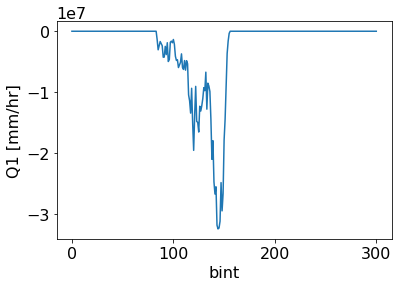

In [ ]:
binned.Q1.plot()

# BL in the mean state

In [4]:
import metpy.calc as mpcalc

In [11]:
from tools.wrfHrTools import change_coords_sfc
temp = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.TEMP.days100-250.nc") #Calculated by breaking down means of 50-day intervals
qvapor = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.QVAPOR.days100-250.nc")
pressure = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.PRESSURE.days100-250.nc")
rain = xr.open_dataarray("/global/homes/q/qnicolas/orographicConvectionTheory/data/wrf.100x2.mountain.3km.precip.days50-200.mean.nc")

In [34]:
dummpy_output = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/wrfpout_d01_1970-01-01_00_00_00_subset.nc")
tmean_p = change_coords_pl(dummpy_output,xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.T_PL.days100-250.nc"))
qmean_p = change_coords_pl(dummpy_output,xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/wrf_saved/channel.wrf.100x2.mountain.60lev.3km/diags/wrf.Q_PL.days100-250.nc"))


In [47]:
def BL_wrf_sigmalevs(t,q,p,lft_top_pressure):
    t_dew = mpcalc.dewpoint_from_specific_humidity(np.array(q), np.array(t)*units.K, np.array(p)*units.Pa)
    zero_array = 0.*p
    thetae = zero_array+np.array(mpcalc.equivalent_potential_temperature(np.array(p)*units.Pa,
                                                                         np.array(t)*units.K,
                                                                         t_dew
                                                                        )/units.K)
    thetaestar = zero_array+np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(p)*units.Pa,
                                                                                        np.array(t)*units.K
                                                                                       )/units.K)
    
    kappaL=3
    g=9.81
    wB = 0.52
    wL = 1-wB
    thetae0 = 340
    
    thetaeB = thetae[:6].mean('bottom_top')
    thetaeL = thetae[6:].where(pressure[6:]>lft_top_pressure*100).mean('bottom_top')
    thetaeLstar = thetaestar[6:].where(pressure[6:]>lft_top_pressure*100).mean('bottom_top')
    
    capeL  = change_coords_sfc((thetaeB/thetaeLstar - 1)*thetae0)
    subsatL = change_coords_sfc((1 - thetaeL/thetaeLstar)*thetae0)
    BL = g/kappaL/thetae0*(wB*capeL-wL*subsatL)
    
    return BL

In [43]:
BL_700hPa = BL_wrf_sigmalevs(temp,qvapor,pressure,700)
BL_500hPa = BL_wrf_sigmalevs(temp,qvapor,pressure,500)


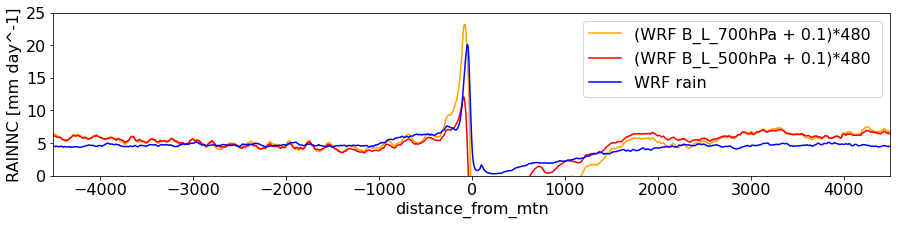

In [39]:
plt.figure(figsize=(15,3))
((BL_700hPa+0.097)*480).plot(label='(WRF B_L_700hPa + 0.1)*480 ',color='orange')
((BL_500hPa+0.075)*480).plot(label='(WRF B_L_500hPa + 0.1)*480 ',color='r')
change_coords_sfc(rain).plot(label='WRF rain',color='b')

plt.ylim(0,25)
plt.xlim(-4500,4500)
plt.legend()

# P-$B_L$ scatterplots with different definitions

In [1]:
# First, look at the continuity between old and 'restarted' simulation
# Transition is great except for a slight precip drop -> need to ditch first 2 days

# In terms of code, the best would be to have a "Simulation" class -> in wrfDeepResolution.ipynb.
# Would take several folders as arguments -> computing means, etc could go into a "combined" folder on cfs.

# Could restart all simulations this way to get more days.

In [3]:
W10S300 = Simulation('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/',1635,3)
#W10S300.data2 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/')
#
#W12S300 = Simulation('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/',1635,3)
#
#W10S296 = Simulation('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/',1635,3)

In [9]:
W10S300.label="10m/s, 300K"
W12S300.label="12m/s, 300K"
W10S296.label="10m/s, 296K"

In [5]:
W10S300.precip = xr.concat((W10S300.data.RAINNC.diff('Time')[200:]*4,W10S300.data2.RAINNC.diff('Time')[8:]*4),'Time').load()
W12S300.precip = W12S300.data.RAINNC.diff('Time')[201:].load()*4
W10S296.precip = W10S296.data.RAINNC.diff('Time')[201:].load()*4


## Computations

In [19]:

W10S300.TEMP = xr.concat((xr.open_zarr(W10S300.path+'diags/wrf.TEMP.days51-200.zarr'),xr.open_zarr(W10S300.path+'diags/wrf.TEMP.days202-315.zarr')),'Time')
#W12S300.TEMP = xr.open_zarr(W12S300.path+'diags/wrf.TEMP.days50-368.zarr')
#W10S296.TEMP = xr.open_zarr(W10S296.path+'diags/wrf.TEMP.days50-254.zarr')

In [20]:
W10S300.Q = xr.concat((W10S300.data.QVAPOR[201:],W10S300.data2.QVAPOR[9:]),'Time')
#W12S300.Q = W12S300.data.QVAPOR[201:]
#W10S296.Q = W10S296.data.QVAPOR[201:]


In [7]:
W10S300.TL = W10S300.TEMP.isel(bottom_top=slice(9,30)).mean('bottom_top')
W12S300.TL = W12S300.TEMP.isel(bottom_top=slice(9,30)).mean('bottom_top')
W10S296.TL = W10S296.TEMP.isel(bottom_top=slice(9,30)).mean('bottom_top')

In [8]:
W10S300.QL = W10S300.Q.isel(bottom_top=slice(9,30)).mean('bottom_top')
W12S300.QL = W12S300.Q.isel(bottom_top=slice(9,30)).mean('bottom_top')
W10S296.QL = W10S296.Q.isel(bottom_top=slice(9,30)).mean('bottom_top')

In [9]:
%time W10S300.TL.to_netcdf(W10S300.path+'diags/wrf.TL.nc')
%time W12S300.TL.to_netcdf(W12S300.path+'diags/wrf.TL.nc')
%time W10S296.TL.to_netcdf(W10S296.path+'diags/wrf.TL.nc')

%time W10S300.QL.to_netcdf(W10S300.path+'diags/wrf.QL.nc')
%time W12S300.QL.to_netcdf(W12S300.path+'diags/wrf.QL.nc')
%time W10S296.QL.to_netcdf(W10S296.path+'diags/wrf.QL.nc')


CPU times: user 47.6 s, sys: 3.95 s, total: 51.6 s
Wall time: 2min 28s
CPU times: user 9.06 s, sys: 1.1 s, total: 10.2 s
Wall time: 45.7 s


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


CPU times: user 8.11 s, sys: 1.76 s, total: 9.87 s
Wall time: 1min 3s
CPU times: user 6.95 s, sys: 1.05 s, total: 8 s
Wall time: 54 s
CPU times: user 9.68 s, sys: 1.19 s, total: 10.9 s
Wall time: 48 s
CPU times: user 6.96 s, sys: 953 ms, total: 7.91 s
Wall time: 28.8 s


In [21]:
W10S300.TB = W10S300.TEMP.isel(bottom_top=slice(0,9)).mean('bottom_top')
#W12S300.TB = W12S300.TEMP.isel(bottom_top=slice(0,9)).mean('bottom_top')
#W10S296.TB = W10S296.TEMP.isel(bottom_top=slice(0,9)).mean('bottom_top')

In [22]:
W10S300.QB = W10S300.Q.isel(bottom_top=slice(0,9)).mean('bottom_top')
#W12S300.QB = W12S300.Q.isel(bottom_top=slice(0,9)).mean('bottom_top')
#W10S296.QB = W10S296.Q.isel(bottom_top=slice(0,9)).mean('bottom_top')

In [23]:

%time W10S300.TB.to_netcdf(W10S300.path+'diags/wrf.TB.nc')
#%time W12S300.TB.to_netcdf(W12S300.path+'diags/wrf.TB.nc')
#%time W10S296.TB.to_netcdf(W10S296.path+'diags/wrf.TB.nc')

%time W10S300.QB.to_netcdf(W10S300.path+'diags/wrf.QB.nc')
#%time W12S300.QB.to_netcdf(W12S300.path+'diags/wrf.QB.nc')
#%time W10S296.QB.to_netcdf(W10S296.path+'diags/wrf.QB.nc')

CPU times: user 42.8 s, sys: 5.67 s, total: 48.4 s
Wall time: 1min 54s
CPU times: user 7.09 s, sys: 750 ms, total: 7.84 s
Wall time: 26.9 s


## Analysis

In [12]:
from tools.BLtools import compute_BLsimple

In [13]:
def get_bins(var,nbins):
    var_sorted = sorted(np.array(var).reshape(-1))
    quantiles=np.linspace(0.,len(var)-1,nbins+1)
    bins = [var_sorted[int(i)]  for i in quantiles]
    bin_centers = [np.mean(var_sorted[int(quantiles[i]):int(quantiles[i+1])]) for i in range(len(quantiles)-1)]
    return np.array(bins)#,np.array(bin_centers)

def select_bootstrap_sample(distribution):
    n=len(distribution)
    return distribution[np.random.randint(0,n,size=n)]
def bootstrap_CI_mean(data,CI_level,nsamples=100):
    """Compute a confidence interval for the mean of a et of data at the level CI_level (0<CI_level<100), using nsamples bootstrap samples"""
    means = np.zeros(nsamples)
    for i in range(nsamples):
        means[i]=select_bootstrap_sample(data).mean()
    return [np.percentile(means,50-CI_level/2),np.percentile(means,50+CI_level/2)]

def get_binned(a,b,bins,itq=False,bootstrap=False):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if itq:
        bin_median = np.array([np.median(np.array(b)[digitized == i]) for i in range(1, len(bins))])
        try:
            bin_q1 = np.array([np.quantile(np.array(b)[digitized == i],0.25) for i in range(1, len(bins))])
            bin_q2 = np.array([np.quantile(np.array(b)[digitized == i],0.75) for i in range(1, len(bins))])
        except IndexError:
            bin_q1 = bin_median
            bin_q2 = bin_median
        return bin_centers,bin_means,bin_median,bin_q1,bin_q2
    elif bootstrap :
        cinf_csup =  np.array([bootstrap_CI_mean(np.array(b)[digitized == i],95) for i in range(1, len(bins))])
        return bin_centers,bin_means,cinf_csup[:,0],cinf_csup[:,1]
    else:
        return bin_centers,bin_means

def get_count(a,bins):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    count = np.histogram(a,bins)[0]
    return bin_centers,count

In [35]:
%%time
W10S300.TL = xr.open_dataset(W10S300.path+'diags/wrf.TL.263days.nc').TEMP
W10S300.QL = xr.open_dataset(W10S300.path+'diags/wrf.QL.263days.nc').QVAPOR
W10S300.QLSTAR = xr.open_dataset(W10S300.path+'diags/wrf.QLSTAR.263days.nc').TEMP
W10S300.TB = xr.open_dataset(W10S300.path+'diags/wrf.TB.263days.nc').TEMP
W10S300.QB = xr.open_dataset(W10S300.path+'diags/wrf.QB.263days.nc').QVAPOR
W10S300.EB = W10S300.TB + 2.5e3*W10S300.QB
W10S300.EL = W10S300.TL + 2.5e3*W10S300.QL
W10S300.ELSTAR = W10S300.TL + 2.5e3*W10S300.QLSTAR

W10S300.BL = compute_BLsimple(W10S300.EB,W10S300.EL,W10S300.ELSTAR,kind='deep')


CPU times: user 20.1 s, sys: 25.6 s, total: 45.7 s
Wall time: 39.9 s


In [36]:
%%time
bins = np.linspace(-0.7,0,21)
centers,means = get_binned(np.array(W10S300.BL).reshape(-1),np.array(W10S300.precip).reshape(-1),bins,bootstrap=False)

CPU times: user 30 s, sys: 17.2 s, total: 47.2 s
Wall time: 41.1 s


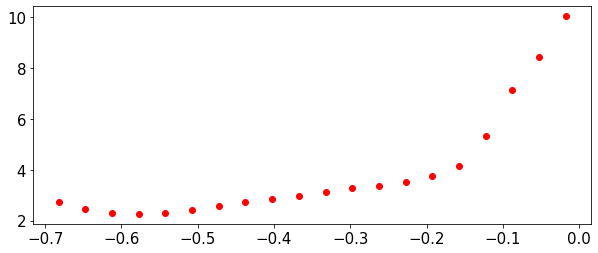

In [37]:
_,ax=plt.subplots(figsize=(10,4))
ax.scatter(centers,means,color='r')

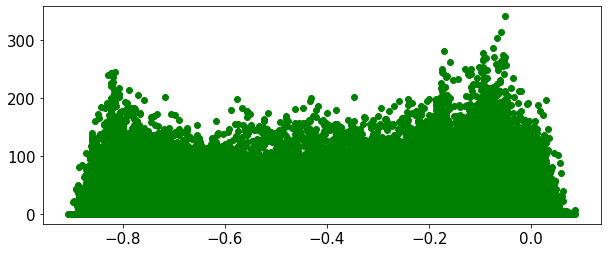

In [39]:
_,ax=plt.subplots(figsize=(10,4))
ax.scatter(W10S300.BL[-10:,:,:-1000:],W10S300.precip[-10:,:,:-1000:],color='g')

In [47]:
testbl = W10S300.BL.coarsen(Time=4).mean()
testpr = W10S300.precip.coarsen(Time=4).mean()

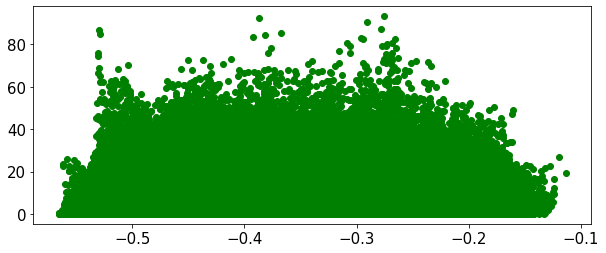

In [48]:
_,ax=plt.subplots(figsize=(10,4))
ax.scatter(testbl[-10:,:,:-1000:],testpr[-10:,:,:-1000:],color='g')

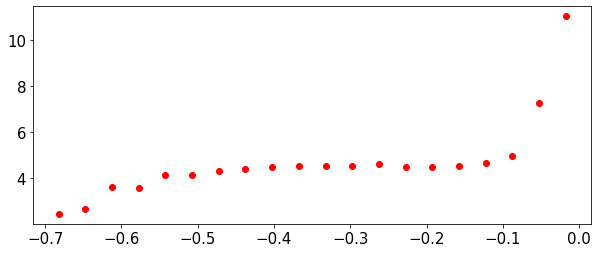

In [49]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-0.7,0,21)
centers,means = get_binned(np.array(testbl).reshape(-1),np.array(testpr).reshape(-1),bins,bootstrap=False)
ax.scatter(centers,means,color='r')

In [50]:
testbl = W10S300.BL.coarsen(Time=4,south_north=6,west_east=6).mean()
testpr = W10S300.precip.coarsen(Time=4,south_north=6,west_east=6).mean()

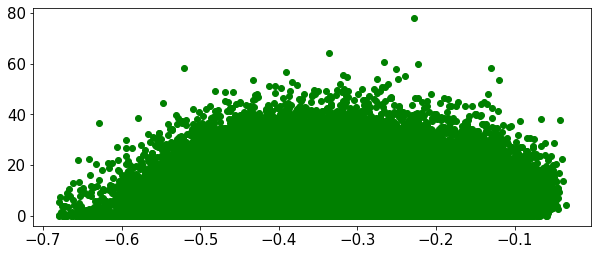

In [51]:
_,ax=plt.subplots(figsize=(10,4))
ax.scatter(testbl,testpr,color='g')

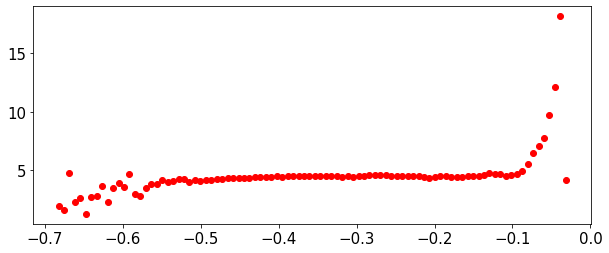

In [54]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-0.7,0,101)
centers,means = get_binned(np.array(testbl).reshape(-1),np.array(testpr).reshape(-1),bins,bootstrap=False)
ax.scatter(centers,means,color='r')

In [71]:
testbl = W10S300.BL[3:-1].coarsen(Time=4,south_north=6,west_east=6).mean()
testpr = W10S300.precip[4:].coarsen(Time=4,south_north=6,west_east=6).mean()

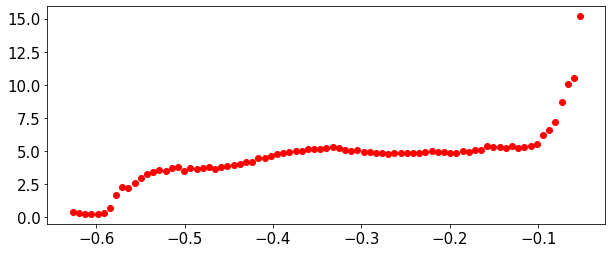

In [75]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-0.7,0,101)
centers,means = get_binned(np.array(testbl[:,:,1700//6:]).reshape(-1),np.array(testpr[:,:,1700//6:]).reshape(-1),bins,bootstrap=False)
ax.scatter(centers,means,color='r')

## With hourly data

In [5]:
W10S300.datapl = extract_wrfpro(W10S300.path)
W12S300.datapl = extract_wrfpro(W12S300.path)
W10S296.datapl = extract_wrfpro(W10S296.path)

In [12]:
for Sim in (W10S300,W12S300,W10S296):
    #t = change_coords_pl(Sim.datapl,Sim.datapl.T_PL[-241:])
    #q = change_coords_pl(Sim.datapl,Sim.datapl.Q_PL[-241:])
    #t=t.where(t>100)
    #q=q.where(q>0)
    #Sim.RAINNCV_HOURLY = change_coords_sfc(Sim.datapl.RAINNCV[-241:])*(86400/16)
    #Sim.TB_HOURLY = t.sel(pressure=slice(1000,850)).mean('pressure')
    #Sim.QB_HOURLY = q.sel(pressure=slice(1000,850)).mean('pressure')
    #%time Sim.EB_HOURLY = (Sim.TB_HOURLY + 2.5e3*Sim.QB_HOURLY).compute()
    #
    #Sim.TL_HOURLY = t.sel(pressure=slice(849,500)).mean('pressure')
    #Sim.QL_HOURLY = q.sel(pressure=slice(849,500)).mean('pressure')
    #%time Sim.EL_HOURLY = (Sim.TL_HOURLY + 2.5e3*Sim.QL_HOURLY).compute()
#
    #Sim.QLSTAR_HOURLY = xr.open_dataarray(Sim.path+'diags/wrf.QLSTAR.hourlytest.nc')
    #Sim.ELSTAR_HOURLY = Sim.TL_HOURLY + 2.5e3*Sim.QLSTAR_HOURLY

    %time Sim.BL_HOURLY = compute_BLsimple(Sim.EB_HOURLY,Sim.EL_HOURLY,Sim.ELSTAR_HOURLY,kind='deep').load()


CPU times: user 10.8 s, sys: 20.5 s, total: 31.2 s
Wall time: 36.9 s
CPU times: user 9.84 s, sys: 20.1 s, total: 29.9 s
Wall time: 29.4 s
CPU times: user 9.58 s, sys: 22.7 s, total: 32.3 s
Wall time: 27.8 s


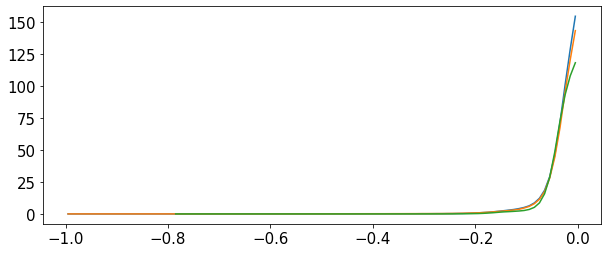

In [13]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0,101)
for Sim in (W10S300,W12S300,W10S296):
    centers,means = get_binned(np.array(Sim.BL_HOURLY).reshape(-1),np.array(Sim.RAINNCV_HOURLY).reshape(-1),bins,bootstrap=False)
    ax.plot(centers,means,label=Sim.label)



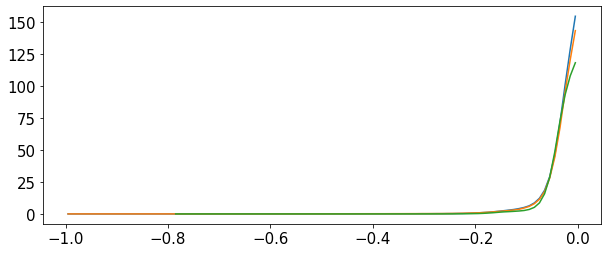

In [11]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0,101)
for Sim in (W10S300,W12S300,W10S296):
    centers,means = get_binned(np.array(Sim.BL_HOURLY).reshape(-1),np.array(Sim.RAINNCV_HOURLY).reshape(-1),bins,bootstrap=False)
    ax.plot(centers,means)



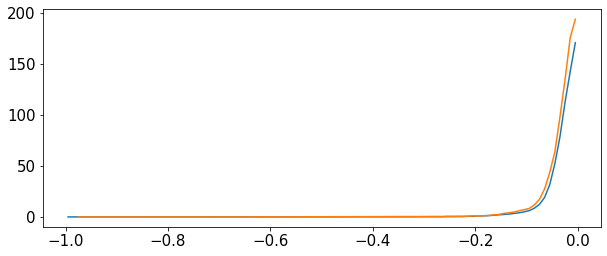

In [15]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0,101)
Sim = W10S300
centers,means = get_binned(np.array(Sim.BL_HOURLY.sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),np.array(Sim.RAINNCV_HOURLY.sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY.sel(distance_from_mtn=slice(-100,-300))).reshape(-1),np.array(Sim.RAINNCV_HOURLY.sel(distance_from_mtn=slice(-100,-300))).reshape(-1),bins,bootstrap=False)

ax.plot(centers,means)



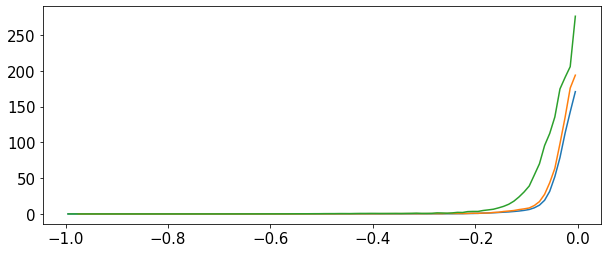

In [17]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0,101)
Sim = W10S300
centers,means = get_binned(np.array(Sim.BL_HOURLY.sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),np.array(Sim.RAINNCV_HOURLY.sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY.sel(distance_from_mtn=slice(-100,-300))).reshape(-1),np.array(Sim.RAINNCV_HOURLY.sel(distance_from_mtn=slice(-100,-300))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY.sel(distance_from_mtn=slice(0,-100))).reshape(-1),np.array(Sim.RAINNCV_HOURLY.sel(distance_from_mtn=slice(0,-100))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)


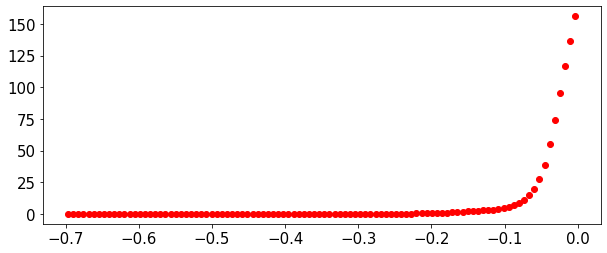

In [47]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0,101)
for Sim in (W10S300,W12S300,W10S296):
    centers,means = get_binned(np.array(Sim.BL_HOURLY).reshape(-1),np.array(Sim.RAINNCV_HOURLY).reshape(-1),bins,bootstrap=False)
    ax.plot(centers,means)



# Hourly data - $\theta_e$-based $B_L$

In [10]:
W10S300.datapl = extract_wrfpro(W10S300.path)
W10S300.RAINNCV_HOURLY = change_coords_sfc(W10S300.datapl.RAINNCV)*(86400/16)
W10S300.BL_HOURLY = xr.open_dataarray(W10S300.path+'diags/wrf.BLDEEP_HOURLY.days1-200.nc')
    

CPU times: user 13 s, sys: 10 s, total: 23 s
Wall time: 23 s


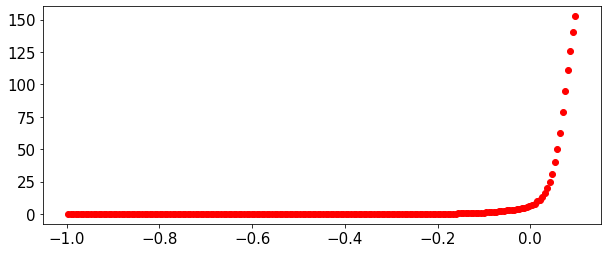

In [18]:
%%time
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0.1,201)
for Sim in (W10S300,):
    centers,means = get_binned(np.array(Sim.BL_HOURLY[-100:]).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-100:]).reshape(-1),bins,bootstrap=False)
    ax.scatter(centers,means,color='r')



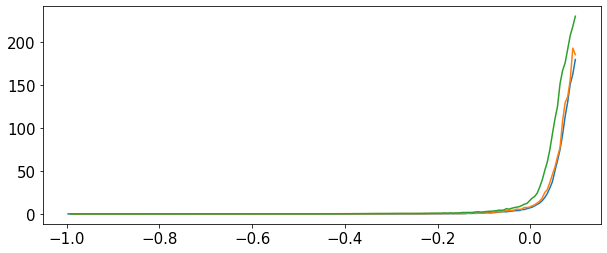

In [42]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0.1,201)
Sim = W10S300
centers,means = get_binned(np.array(Sim.BL_HOURLY[-100:].sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-100:].sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY[-200:].sel(distance_from_mtn=slice(-100,-300))).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-200:].sel(distance_from_mtn=slice(-100,-300))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY[-1000:].sel(distance_from_mtn=slice(0,-100))).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-1000:].sel(distance_from_mtn=slice(0,-100))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

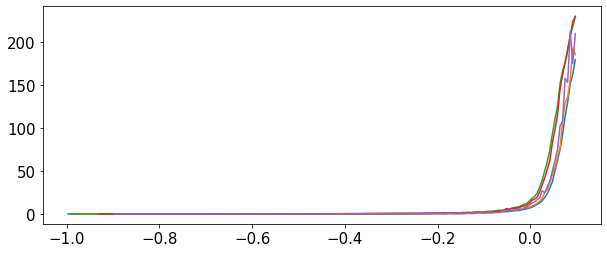

In [43]:
_,ax=plt.subplots(figsize=(10,4))
bins = np.linspace(-1,0.1,201)
Sim = W10S300
centers,means = get_binned(np.array(Sim.BL_HOURLY[-100:].sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-100:].sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY[-200:].sel(distance_from_mtn=slice(-100,-300))).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-200:].sel(distance_from_mtn=slice(-100,-300))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY[-1000:].sel(distance_from_mtn=slice(0,-100))).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-1000:].sel(distance_from_mtn=slice(0,-100))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY[-1000:].sel(distance_from_mtn=slice(-50,-100))).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-1000:].sel(distance_from_mtn=slice(-50,-100))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

centers,means = get_binned(np.array(Sim.BL_HOURLY[-1000:].sel(distance_from_mtn=slice(-90,-100))).reshape(-1),np.array(Sim.RAINNCV_HOURLY[-1000:].sel(distance_from_mtn=slice(-90,-100))).reshape(-1),bins,bootstrap=False)
ax.plot(centers,means)

Text(0.5, 1.0, 'PDF of $B_L$')

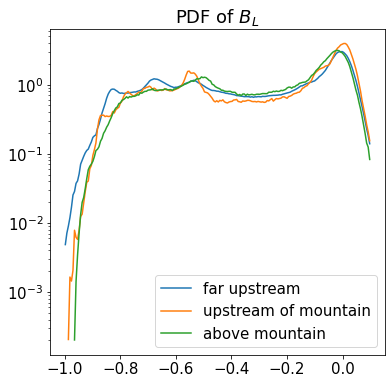

In [35]:
_,ax=plt.subplots(figsize=(6,6))
bins = np.linspace(-1,0.1,201)
Sim = W10S300
centers,count = get_count(np.array(Sim.BL_HOURLY[-100:].sel(distance_from_mtn=slice(-1000,-6000))).reshape(-1),bins)
ax.plot(centers,count/np.trapz(count,centers),label='far upstream')
ax.set_yscale('log')

centers,count = get_count(np.array(Sim.BL_HOURLY[-200:].sel(distance_from_mtn=slice(-100,-300))).reshape(-1),bins)
ax.plot(centers,count/np.trapz(count,centers),label='upstream of mountain')

centers,count = get_count(np.array(Sim.BL_HOURLY[-400:].sel(distance_from_mtn=slice(0,-100))).reshape(-1),bins)
ax.plot(centers,count/np.trapz(count,centers),label='above mountain')

ax.legend()
ax.set_title(r'PDF of $B_L$')